In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility.
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Ignore warnings.
warnings.filterwarnings('ignore')

## <a style="color:purple;">**Analysis of the US Economy**</a> - part 3

#### Author: @**engine**, Date: February 2025, Deep Learning project

### Abstract:
**!!!** TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... <b>!!!</b>

### 1. **Introduction**

This study is a continuation of the previous two. The latter predicted the likelihood of a recession and indicated why one might not be declared. From here we ask ourselves the next logical question: can we measure the resilience of the US economy? And how? And also, how does US debt fit into all these processes of economic sustainability?

On the site **[Sustainable Economic Indicators](https://www.sustainable-environment.org.uk/Indicators/Economy.php)** we read:<br>
**Total GDP** and **GDP per capita** are good indicators of the relative strengths of the worlds nations.
Other indicators may include:

 - Investment in public, business and private assets (headline);
 - Social investment;
 - Rate of inflation;
 - Government borrowing and debt;
 - Competitiveness/productivity;
 - Trade/exports/imports.

However, it is increasingly being recognised these traditional economic indicators alone do not provide an adequate measure of an economy’s sustainability. To improve upon these indicators, we need to know how resource efficient our economy is, both in terms of the natural resources that it consumes (and wastes) and its utilisation of labour capital. Some indicators that have been proposed by the Government in this respect include:

 - Waste production, and energy and water consumption;
 - Transport indicators;
 - Education and employment;
 - Consumer expenditure;
 - Environmental management and reporting. [1]

This study **<a style="color:purple;">cannot cover all aspects of the sustainability of an economy</a>**, from internal social contradictions... to the state of the environment (ecology). But we **can safely use the most important indicators, which we can put into numbers** and then with **AI models**:

- **GROSS DOMESTIC PRODUCT** (**<a style="color:purple;">GDP</a>**) => Competitiveness/productivity;
- **Real GDP per capita** (A939RX0Q048SBEA) => Competitiveness/productivity;
- **Total Public Debt as Percent of GDP** (GFDEGDQ188S) => Competitiveness/productivity;<br>

- **Consumer Price Index** (CPI) => Consumer expenditure;
- **Industrial Production Index** (INDPRO) => Competitiveness/productivity;
- **S&P 500 Index** (SP500) => Investment in public, business and private assets;
- **Total Nonfarm Payroll** (PAYEMS) => Competitiveness/productivity (jobs);
- **Unemployment** (UNRATE) => Education and employment;
- **Federal Funds Effective Rate** (FEDFUNDS) => Rate of inflation;
- **Federal Debt: Total Public Debt** (GFDEBTN) => Government borrowing and debt;
- **Personal Saving Rate** (PSAVERT) => Social investment;
- **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB) => Trade/exports/imports;
- Personal consumption expenditures: **Energy goods and services** (DNRGRC1M027SBEA) => Waste production, and energy and water consumption.

For some of the data we will be able to easily interpolate back in time. Some of the data that we can include are not freely available, and others are either abandoned for collection back in time, or are being collected recently. **Back in time**, in the general case, we get a practical limit from **January 1966**, and for the moment we only have a limited amount of this data, which is published quarter by quarter. And with a great delay.

### 2. **Collection of economic indicators**

#### 2.1 **GROSS DOMESTIC PRODUCT** (GDP)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GDP)** we only download information for the period of our study: **<a style="color:purple;">Gross Domestic Product (GDP)</a>**. [001] Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [5]:
gdp = pd.read_csv('data/GDP.csv') # Read the CSV file.
gdp.columns = ["date", "gdp"]
gdp['gdp'] = gdp['gdp'] * 1_000_000_000 # Convert to dollars.

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1962** to **the end of the study period**, we use a **linear approximation**.

In [7]:
gdp['date'] = pd.to_datetime(gdp['date'])
gdp_approx = gdp.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
gdp_approx = pd.merge(gdp_all_dates, gdp, on='date', how='left')

# Linear interpolation.
gdp_approx['gdp'] = gdp_approx['gdp'].interpolate(method='linear')

# Remove the 'year' and 'month' columns.
if 'year' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['year'])
if 'month' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['month'])
gdp_approx.tail()

,date,gdp
700,2024-05-01,2.912778e+13
701,2024-06-01,2.923885e+13
702,2024-07-01,2.934992e+13
703,2024-08-01,2.934992e+13
704,2024-09-01,2.934992e+13


#### 2.2 **CONSUMER PRICE INDEX** (CPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/CPIAUCSL)** we only download information for the period of our study: **<a style="color:purple;">Consumer Price Index (CPI)</a>** for All Urban Consumers, All Items in U.S. City Average (CPIAUCSL). [xx] Units: **Index**, Seasonally Adjusted. Frequency: Monthly.

In [9]:
cpi = pd.read_csv('data/CPIAUCSL.csv') # Read the CSV file.
cpi.columns = ["date", "cpi"]
cpi.tail()

,date,cpi
700,2024-05-01,313.225
701,2024-06-01,313.049
702,2024-07-01,313.534
703,2024-08-01,314.121
704,2024-09-01,314.686


#### 2.3 **Industrial Production Index** (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **<a style="color:purple;">Industrial Production Index (INDPRO)</a>** [xx], Seasonally Adjusted. Frequency: Monthly.

In [11]:
indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file.
indpro.columns = ["date", "indpro"]
indpro.tail()

,date,indpro
700,2024-05-01,103.0711
701,2024-06-01,103.2258
702,2024-07-01,102.5863
703,2024-08-01,102.9329
704,2024-09-01,102.6418


#### 2.4 **S&P 500 Index** (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **<a style="color:purple;">S&P 500 Index (SP500)</a>** [xx], Frequency: Monthly. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [13]:
sp = pd.read_csv('data/SP500.csv') # Read the CSV file.
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp
# Renaming columns.
sp500.columns = ['date', 'sp500']
sp500.tail()

,date,sp500
700,2024-05-31,5277.51
701,2024-06-30,5460.48
702,2024-07-31,5522.30
703,2024-08-31,5648.40
704,2024-09-30,5762.48


#### 2.5 **Total Nonfarm Payroll** (PAYEMS)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PAYEMS)** we download information for the period of our study: **<a style="color:purple;">Total Nonfarm Payroll (PAYEMS)</a>** [xx], Units: **Thousands of Persons**, Seasonally Adjusted. Frequency: Monthly.

In [15]:
payems = pd.read_csv('data/PAYEMS.csv') # Read the CSV file.
payems.columns = ["date", "payems"]
payems.tail()

,date,payems
700,2024-05-01,158430
701,2024-06-01,158548
702,2024-07-01,158692
703,2024-08-01,158851
704,2024-09-01,159105


#### 2.6 **UNEMPLOYMENT** (UNRATE)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we only download information for the period of our study: **<a style="color:purple;">Monthly Unemployment Rate (UNRATE)</a>**. [xx] Units: **Percent**</a>, Seasonally Adjusted. Frequency: Monthly. 

In [17]:
unrate = pd.read_csv('data/UNRATE.csv') # Read the CSV file.
unrate.columns = ["date", "unrate"]
unrate["unrate"] = unrate["unrate"] / 100 # To get in percentages.
unrate.tail()

,date,unrate
700,2024-05-01,0.040
701,2024-06-01,0.041
702,2024-07-01,0.043
703,2024-08-01,0.042
704,2024-09-01,0.041


#### 2.7 **Federal Funds Effective Rate** (FEDFUNDS)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/FEDFUNDS)** we only download information for the period of our study: **<a style="color:purple;">Federal Funds Effective Rate (FEDFUNDS)</a>**, Units: **Percent**. Frequency: Monthly [xx]

In [19]:
fedfunds = pd.read_csv('data/FEDFUNDS.csv') # Read the CSV file.
fedfunds.columns = ["date", "fedfunds"]
fedfunds["fedfunds"] = fedfunds["fedfunds"] / 100 # To get in percentages.
fedfunds.tail()

,date,fedfunds
700,2024-05-01,0.0533
701,2024-06-01,0.0533
702,2024-07-01,0.0533
703,2024-08-01,0.0533
704,2024-09-01,0.0513


#### 2.8 **Total Public Debt** (GFDEBTN)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/GFDEBTN)** we only download information for the period of our study: **<a style="color:purple;">Federal Debt: Total Public Debt (GFDEBTN)</a>**, Units: **Millions of Dollars**, Not Seasonally Adjusted. Frequency: Quarterly [xx]

In [21]:
debt = pd.read_csv('data/GFDEBTN.csv') # Loading data.
debt.columns = ["date", "debt"]
debt['debt'] = debt['debt'] * 1_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
debt['date'] = pd.to_datetime(debt['date'])

# Create a new DataFrame with all dates from 1966-01-01 to the end of the period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
debt_all_dates = pd.DataFrame({'date': all_dates})

# Merging the two DataFrames and interpolation.
debt_approx = pd.merge(debt_all_dates, debt, on='date', how='left')

# Linear interpolation.
debt_approx['debt'] = debt_approx['debt'].interpolate(method='linear')

# Remove the 'year' and 'month' columns, if they exist.
if 'year' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['year'])
if 'month' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['month'])
    
debt_approx.tail()

,date,debt
700,2024-05-01,3.504265e+13
701,2024-06-01,3.525366e+13
702,2024-07-01,3.546467e+13
703,2024-08-01,3.546467e+13
704,2024-09-01,3.546467e+13


#### 2.9 **Personal Saving Rate** (PSAVERT)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/graph/?g=580A)** we only download information for the period of our study: **<a style="color:purple;">Personal Saving Rate (PSAVERT)</a>**, Units: **Percent**, Seasonally Adjusted. Frequency: Monthly [xx]<br> 
Personal saving is equal to personal income less personal outlays and personal taxes; it may generally be viewed as the portion of personal income that is used either to provide funds to capital markets or to invest in real assets such as residences.

In [23]:
pasavert = pd.read_csv('data/PSAVERT.csv') # Loading data.
pasavert.columns = ["date", "pasavert"]
pasavert["pasavert"] = pasavert["pasavert"] / 100 # To get in percentages.
pasavert.tail()

,date,pasavert
700,2024-05-01,0.052
701,2024-06-01,0.052
702,2024-07-01,0.049
703,2024-08-01,0.048
704,2024-09-01,0.046


#### 2.10 **Real gross domestic product per capita** (A939RX0Q048SBEA)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/A939RX0Q048SBEA)** we only download information for the period of our study: **<a style="color:purple;">Real gross domestic product per capita (A939RX0Q048SBEA)</a>**. [xx] Units: **Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [25]:
gdp_pca = pd.read_csv('data/A939RX0Q048SBEA.csv') # Read the CSV file.
gdp_pca.columns = ["date", "gdp_pca"]

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1966** to **the end of the study period**, we use a **linear approximation**.

In [27]:
gdp_pca['date'] = pd.to_datetime(gdp_pca['date'])
gdp_pca_approx = gdp_pca.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_pca_all_dates = pd.DataFrame({'date': all_dates})

# Merge with the correct DataFrame (gdp_pca instead of gdp).
gdp_pca_approx = pd.merge(gdp_pca_all_dates, gdp_pca, on='date', how='left')

# Linear interpolation.
gdp_pca_approx['gdp_pca'] = gdp_pca_approx['gdp_pca'].interpolate(method='linear')

# Remove the 'year' and 'month' columns if they exist.
if 'year' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['year'])
if 'month' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['month'])

gdp_pca_approx.tail()

,date,gdp_pca
700,2024-05-01,69103.666667
701,2024-06-01,69230.333333
702,2024-07-01,69357.000000
703,2024-08-01,69357.000000
704,2024-09-01,69357.000000


#### 2.11 **Total Public Debt as Percent of Gross Domestic Product** (GFDEGDQ188S)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GFDEGDQ188S)** we can download information for the period of our study: **<a style="color:purple;">Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)</a>**. [xx] Units: **Percent of GDP**, Seasonally Adjusted. Frequency: Quarterly. Here we have a **problem**. Of all the economic indicators, this one is updated the latest, i.e. **has the largest time lag**! However, we **can simply calculate it** based on the data already collected:

In [29]:
# We calculate: Total Public Debt as Percent of Gross Domestic Product.
debt_per_gdp = pd.DataFrame() # Creating a new DataFrame.
# Copy dates.
debt_per_gdp['date'] = gdp_approx['date']

# Calculating the debt-to-GDP ratio.
debt_per_gdp['debt_per_gdp'] = (debt_approx['debt'] / gdp_approx['gdp'])
debt_per_gdp.tail()

,date,debt_per_gdp
700,2024-05-01,1.203066
701,2024-06-01,1.205713
702,2024-07-01,1.208340
703,2024-08-01,1.208340
704,2024-09-01,1.208340


#### 2.12 **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/BOPGSTB)** we download information for the period of our study: **<a style="color:purple;">Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)</a>**. [xx] Units: **Millions of Dollars**, Seasonally Adjusted. Frequency: Quarterly. Monthly [xx] Here we have a problem. The information has only been collected since January 1992. Looking at the graph of this indicator from the site **[United States Balance of Trade](https://tradingeconomics.com/united-states/balance-of-trade)** [xx], we can apply interpolation to generate data back to January 1966. Because the data is not freely available, but is paid for.<br><br>
![US Balance of Trade](data/Balance_of_Trade.png)

In [31]:
tb_file = pd.read_csv('data/BOPGSTB.csv') # Loading data.
tb_file.columns = ["date", "tb"]
tb_file['tb'] = tb_file['tb'] * 1_000_000 # Convert to dollars.

The last date with data is January 1992. Using **[CLAUDE.ai](https://claude.ai/)** we approximate the missing data to January 1966. The missing values ​​are not large in absolute value and the error will be many times smaller than if we use linear approximation. We receive from **Claude.ai** a file in **.csv** format with dates from **January 1966** to **December 1991**. We load and merge the data for the trade balance into one file.

In [33]:
approx_file = pd.read_csv('data/TB_approx.csv') # Loading data.
approx_file.columns = ["date", "tb"]
approx_file['tb'] = approx_file['tb'] * 1_000_000 # Convert to dollars.

# Merge the two DataFrames.
tb = pd.concat([approx_file, tb_file], ignore_index=True)

# Sort by date.
tb = tb.sort_values('date')
# Remove any duplicate entries.
tb = tb.drop_duplicates(subset=['date'], keep='last')

tb.tail()

,date,tb
700,2024-05-01,-7.530600e+10
701,2024-06-01,-7.301600e+10
702,2024-07-01,-7.891800e+10
703,2024-08-01,-7.078700e+10
704,2024-09-01,-8.435900e+10


#### 2.13  **Personal consumption expenditures: Energy goods and services** (DNRGRC1M027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/DNRGRC1M027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Energy goods and services (DNRGRC1M027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Monthly [xx]

In [35]:
energy = pd.read_csv('data/DNRGRC1M027SBEA.csv') # Loading data.
energy.columns = ['date', 'energy']
energy['energy'] = energy['energy'] * 1_000_000_000 # Convert to dollars.
energy.tail()

,date,energy
700,2024-05-01,7.823000e+11
701,2024-06-01,7.600000e+11
702,2024-07-01,7.668000e+11
703,2024-08-01,7.536000e+11
704,2024-09-01,7.417000e+11


#### 2.14 **Federal government current expenditures: Interest payments** (A091RC1Q027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/A091RC1Q027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Federal government current expenditures: Interest payments (A091RC1Q027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly [xx]

In [37]:
interest = pd.read_csv('data/A091RC1Q027SBEA.csv') # Read the CSV file.
interest.columns = ["date", "interest"]
interest['interest'] = interest['interest'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
interest['date'] = pd.to_datetime(interest['date'])

# Create a new DataFrame with all dates from 1966-01-01 to the end of the period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
interest_all_dates = pd.DataFrame({'date': all_dates})

# Merging the two DataFrames and interpolation.
interest_approx = pd.merge(interest_all_dates, interest, on='date', how='left')

# Linear interpolation.
interest_approx['interest'] = interest_approx['interest'].interpolate(method='linear')

# Remove the 'year' and 'month' columns, if they exist.
if 'year' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['year'])
if 'month' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['month'])
    
interest_approx.tail()

,date,interest
700,2024-05-01,1.103514e+12
701,2024-06-01,1.110237e+12
702,2024-07-01,1.116960e+12
703,2024-08-01,1.116960e+12
704,2024-09-01,1.116960e+12


#### 2.15 **Federal government current tax receipts** (W006RC1Q027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/W006RC1Q027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Federal government current tax receipts (W006RC1Q027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly [xx]

In [39]:
tax = pd.read_csv('data/W006RC1Q027SBEA.csv') # Read the CSV file.
tax.columns = ["date", "tax"]
tax['tax'] = tax['tax'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
tax['date'] = pd.to_datetime(tax['date'])

# Create a new DataFrame with all dates from 1966-01-01 to the end of the period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
tax_all_dates = pd.DataFrame({'date': all_dates})

# Merging the two DataFrames and interpolation.
tax_approx = pd.merge(tax_all_dates, tax, on='date', how='left')

# Linear interpolation.
tax_approx['tax'] = tax_approx['tax'].interpolate(method='linear')

# Remove the 'year' and 'month' columns, if they exist.
if 'year' in tax_approx.columns:
    tax_approx = tax_approx.drop(columns=['year'])
if 'month' in tax_approx.columns:
    tax_approx = tax_approx.drop(columns=['month'])
    
tax_approx.tail()

,date,tax
700,2024-05-01,3.086729e+12
701,2024-06-01,3.094660e+12
702,2024-07-01,3.102590e+12
703,2024-08-01,3.102590e+12
704,2024-09-01,3.102590e+12


#### 2.16 **Slope of the yield curve** (T10YFF):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/T10YFF)** we download information for the period of our study: **<a style="color:purple;">Slope of the yield curve (T10YFF)</a>**. [xx] Units: **Percent**, Seasonally Adjusted, Frequency: Daily.

In [41]:
t10yff = pd.read_csv('data/T10YFF.csv') # Read the CSV file.
t10yff.columns = ["date", "t10yff"]
# Replace '.' with NaN and convert column 't10yff' to numeric type.
t10yff['t10yff'] = pd.to_numeric(t10yff['t10yff'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
t10yff['date'] = pd.to_datetime(t10yff['date'])
t10yff.set_index('date', inplace=True)
t10yff_avg = t10yff.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
t10yff_avg = t10yff_avg.reset_index()
t10yff_avg.tail()

,date,t10yff
700,2024-05-01,-0.847727
701,2024-06-01,-1.024737
702,2024-07-01,-1.081364
703,2024-08-01,-1.459091
704,2024-09-01,-1.406500


#### 2.17 **Federal Government: Current Expenditures** (FGEXPND):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/FGEXPND)** we download information for the period of our study: **<a style="color:purple;">Federal Government: Current Expenditures (FGEXPND)</a>**. [xx] Units: **Billions of Dollars**, Seasonally Adjusted, Frequency: Quarterly.

In [43]:
fgexpnd = pd.read_csv('data/FGEXPND.csv') # Read the CSV file.
fgexpnd.columns = ["date", "fgexpnd"]
fgexpnd['fgexpnd'] = fgexpnd['fgexpnd'] * 1_000_000_000 # Convert to dollars.

# Convert column 'date' to datetime.
fgexpnd['date'] = pd.to_datetime(fgexpnd['date'])

# Create a new DataFrame with all dates from 1966-01-01 to the end of the period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
fgexpnd_all_dates = pd.DataFrame({'date': all_dates})

# Merging the two DataFrames and interpolation.
fgexpnd_approx = pd.merge(fgexpnd_all_dates, fgexpnd, on='date', how='left')

# Linear interpolation.
fgexpnd_approx['fgexpnd'] = fgexpnd_approx['fgexpnd'].interpolate(method='linear')

# Remove the 'year' and 'month' columns, if they exist.
if 'year' in fgexpnd_approx.columns:
    fgexpnd_approx = fgexpnd_approx.drop(columns=['year'])
if 'month' in fgexpnd_approx.columns:
    fgexpnd_approx = tax_fgexpnd.drop(columns=['month'])
    
fgexpnd_approx.tail()

,date,fgexpnd
700,2024-05-01,6.927587e+12
701,2024-06-01,6.990586e+12
702,2024-07-01,7.053586e+12
703,2024-08-01,7.053586e+12
704,2024-09-01,7.053586e+12


#### 2.xx Preprocessing data

In [45]:
# Create a new empty table.
data = pd.DataFrame(columns=[
    'gdp', # GROSS DOMESTIC PRODUCT
    'cpi', # Consumer price index
    'indpro', # Industrial Production Index
    'sp500', # S&P 500 Index
    'payems', # Total Nonfarm Payroll
    'unrate', # Unemployment
    'fedfunds', # Federal Funds Effective Rate
    'debt', # Total Public Debt
    'pasavert', #  Personal Saving Rate
    'gdp_pca', # Real GDP per capita
    'debt_per_gdp', # Total Public Debt as Percent of GDP
    'tb', # Trade Balance
    'energy', # PCE: Energy goods and services
    'interest', # Federal government interest payments
    'tax', # Federal government current tax receipts
    'fgexpnd', # Federal Government Current Expenditures
    't10yff' # Slope of the yield curve
])
# Add data to the columns.
data['gdp'] = gdp_approx['gdp']                # _ USD
data['cpi'] = cpi['cpi']                       # ______ Index
data['indpro'] = indpro['indpro']              # ______ Index
data['sp500'] = sp500['sp500']                 # ______ Index
data['payems'] = payems['payems']              # ______ Persons
data['unrate'] = unrate['unrate']              # ______ Percent
data['fedfunds'] = fedfunds['fedfunds']        # ______ Percent
data['debt'] = debt_approx['debt']             # _ USD
data['pasavert'] = pasavert['pasavert']        # ______ Percent
data['gdp_pca'] = gdp_pca_approx['gdp_pca']    # _ USD
data['debt_per_gdp'] = debt_per_gdp['debt_per_gdp'] # _ Percent
data['tb'] = tb['tb']                          # _ USD
data['energy'] = energy['energy']              # _ USD
data['interest'] = interest_approx['interest'] # _ USD
data['tax'] = tax_approx['tax']                # _ USD
data['fgexpnd'] = fgexpnd_approx['fgexpnd']    # _ USD
data['t10yff'] = t10yff_avg['t10yff']          # ______ Percent

In [46]:
# Create list of monthly dates.
dates = pd.date_range(start='01-1966', end='09-2024', freq='MS')
formatted_dates = pd.to_datetime(dates)

# Assuming collected_data is already an existing DataFrame with some data.
# Check the length of data to ensure it matches the length of formatted_dates.
if len(data) == len(formatted_dates):
    data['date'] = formatted_dates
else:
    print("The length of collected_data does not match the length of formatted_dates!")
data.set_index('date', inplace=True)

data.to_csv(r'data/data.csv') # We save the dataframe to a file.

data

,gdp,cpi,indpro,sp500,payems,unrate,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,energy,interest,tax,fgexpnd,t10yff
date,,,,,,,,,,,,,,,,,
1966-01-01,7.957340e+11,31.880,33.1709,92.88,62529,0.040,0.0442,3.209990e+11,0.112,24172.000000,0.403400,-3.500000e+06,3.120000e+10,1.944000e+10,9.869200e+10,1.360560e+11,0.288095
1966-02-01,7.988163e+11,32.080,33.3859,91.22,62796,0.038,0.0460,3.193650e+11,0.110,24178.333333,0.399798,-3.600000e+06,3.090000e+10,1.962933e+10,1.001187e+11,1.381690e+11,0.242632
1966-03-01,8.018987e+11,32.180,33.8429,89.23,63192,0.038,0.0466,3.177310e+11,0.107,24184.666667,0.396223,-3.700000e+06,3.120000e+10,1.981867e+10,1.015453e+11,1.402820e+11,0.229565
1966-04-01,8.049810e+11,32.280,33.8967,91.06,63437,0.038,0.0467,3.160970e+11,0.103,24191.000000,0.392676,-3.800000e+06,3.170000e+10,2.000800e+10,1.029720e+11,1.423950e+11,0.111500
1966-05-01,8.098667e+11,32.350,34.2192,86.13,63712,0.039,0.0490,3.189807e+11,0.112,24234.333333,0.393868,-3.900000e+06,3.200000e+10,2.016800e+10,1.034133e+11,1.439157e+11,-0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,2.912778e+13,313.225,103.0711,5277.51,158430,0.040,0.0533,3.504265e+13,0.052,69103.666667,1.203066,-7.530600e+10,7.823000e+11,1.103514e+12,3.086729e+12,6.927587e+12,-0.847727
2024-06-01,2.923885e+13,313.049,103.2258,5460.48,158548,0.041,0.0533,3.525366e+13,0.052,69230.333333,1.205713,-7.301600e+10,7.600000e+11,1.110237e+12,3.094660e+12,6.990586e+12,-1.024737
2024-07-01,2.934992e+13,313.534,102.5863,5522.30,158692,0.043,0.0533,3.546467e+13,0.049,69357.000000,1.208340,-7.891800e+10,7.668000e+11,1.116960e+12,3.102590e+12,7.053586e+12,-1.081364


### 3. **Analysis of economic sustainability**

#### 3.1 **First simulation**:

**Input**: 17 features.<br>
**Target**: Composite Health Score (we will create it as a weighted sum of normalized metrics).<br>
**Model**: Hybrid 1D CNN + LSTM architecture<br>
**Objective**: Assessing overall economic health by forecasting a composite index based on economic indicators and time series.<br><br>
Main functionalities of the model:<br>

1. Creating a composite economic health index:
    The index is based on weighted values ​​of economic indicators. Positive and negative metrics have a total weight of 1 and -1, respectively, which ensures a balanced measurement of economic conditions.

2. Using LSTM for temporal dependencies:
    Two LSTM layers allow capturing short-term and long-term dependencies in economic data.

3. Application of Dropout to prevent overfitting:
    After each LSTM layer, a Dropout layer with a coefficient of 0.3 is included to reduce the risk of overfitting.

4. Preparation of time series data:
    The data is prepared as sequences using the prepare_sequences function to make it suitable for time series training.

5. Data Normalization:
    Input and output data are normalized using MinMaxScaler to improve training stability.

5. Results Visualization:
    Training Process: Plots of loss and MAE (mean absolute error) metrics.
    Predictions: Plots for comparison between actual and predicted values, noting the standard deviation around the predictions.

Model Architecture:

The model combines 1D Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers to take advantage of the advantages of both technologies:

 - **Conv1D** layer: Captures local temporal dependencies in sequences (kernel_size=5, 128 filters).
 - **MaxPooling1D** layer: Reduces the dimensionality of the output from the Conv1D layer.
 - First **LSTM** layer: Captures short-term and intermediate dependencies (256 units, return_sequences=True).
 - **Dropout** layer: To prevent overfitting.
 - Second **LSTM** layer: Summarizes the sequence into a single output vector (128 units, return_sequences=False).
 - **Dropout** layer: Reduces the risk of overfitting.
 - **Dense** layers:
    64 units (ReLU activation) for additional processing.
    1 unit for the final prediction (economic health).

Detailed description of the functionalities:

**CNN part**: 1D Convolution is applied to the time series to extract key local features from the input data. This is useful for recognizing patterns related to economic indicators.

**LSTM part**: Captures both short-term and long-term dependencies in economic data. The first LSTM layer preserves full consistency, while the second summarizes all the information into a single vector.

**Composite index**: The index combines positive and negative indicators with normalized weights to provide an objective measure of economic health.

**Predictions**: The model predicts future values ​​of economic health based on consistent data from the past.

Advantages of the approach:

 - The hybrid architecture (CNN + LSTM) combines spatial and temporal analysis.
 - Normalization ensures stability of the training.
 - Dropout layers prevent overfitting, even with complex architectures.
 - The composite index offers an intuitive and interpretable measurement of economic health.

##### Here is a justification for the chosen weights in the new model:

**Positive indicators** (total = 1.0):

 - GDP (0.15): Main indicator of economic growth. Lower coefficient than the maximum 0.2, because sometimes GDP can grow without reflecting real welfare.
 - INDPRO (0.15): Industrial production directly indicates economic potential. Equally important with GDP, because it reflects real production activity.
 - GDP_PCA (0.15): Per capita income: a direct indicator of the standard of living. Equal to GDP and industrial production due to the direct link to welfare.
 - PAYEMS (0.10): Employment is a important indicator of economic stability. As much as GDP and INDPRO, because it directly affects social dynamics.
 - PASAVERT (0.10): Savings indicate financial stability of households, but with less weight because they are a more indirect indicator.
 - SP500 (0.10): The stock market index reflects market sentiment, but is more volatile and subjective.
 - TAX (0.10): Tax revenues indicate economic activity, but are a more productive indicator.
 - INTEREST (0.10): Interest payments show financial dynamics, but are a more peripheral indicator.
 - T10YFF (0.05): The slope of the yield curve is an important, but most nuanced signal.

**Negative indicators** (total = -1.0):

 - DEBT (-0.25): Public debt is the most critical risk, therefore it has the largest negative weight.
 - CPI (-0.15): Inflation directly destroys economic stability, the second most important negative factor.
 - TB (-0.15): The trade balance shows external economic health, significant, but not so critical.
 - UNRATE (-0.10): Unemployment is an important social indicator.
 - FEDFUNDS (-0.10): Interest rates affect borrowing and investment.
 - DEBT_PER_GDP (-0.10): The debt/GDP ratio further describes the debt picture.
 - FGEXPND (-0.10): Government spending indicates economic management.
 - ENERGY (-0.05): Least weighted because it is a more specific indicator.

The logic is to create a balanced composite index that:
 - Captures different economic dimensions.
 - Gives more weight to fundamental indicators.
 - Balances positive and negative signals. The sum of all weights is zero, which provides a balanced model.
 - Reflects the complexity of the economic system.<br>

In [49]:
def model_evaluation(true_values, predictions, threshold=0):
   binary_predictions = (predictions > threshold).astype(int)
   binary_true = (true_values > threshold).astype(int)
   
   metrics = {
       'rmse': np.sqrt(mean_squared_error(true_values, predictions)),
        'mae': mean_absolute_error(true_values, predictions),
        'r2': r2_score(true_values, predictions)
   }
   return metrics

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    # The error between predicted and actual values.
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    # The average absolute difference between predicted and actual values.
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )

    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Training the model...


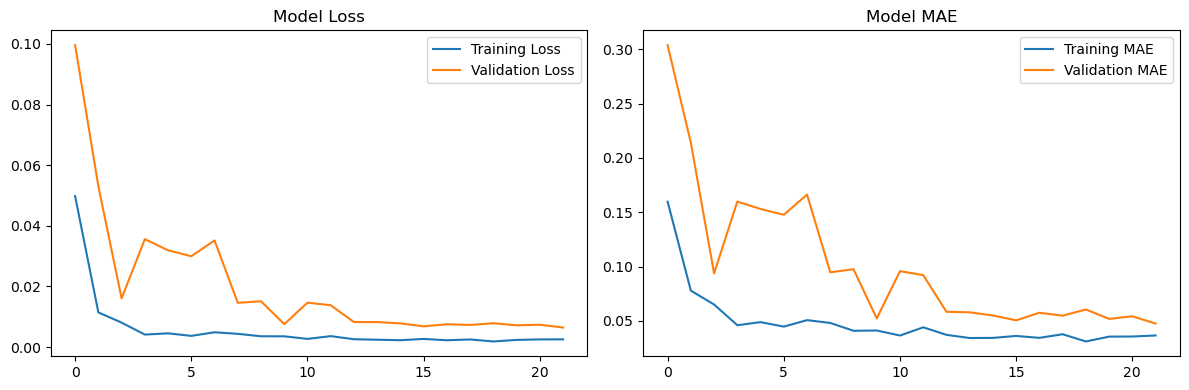


Model Eval. Metrics: rmse: 0.020, r2: 0.970, mae: 0.012




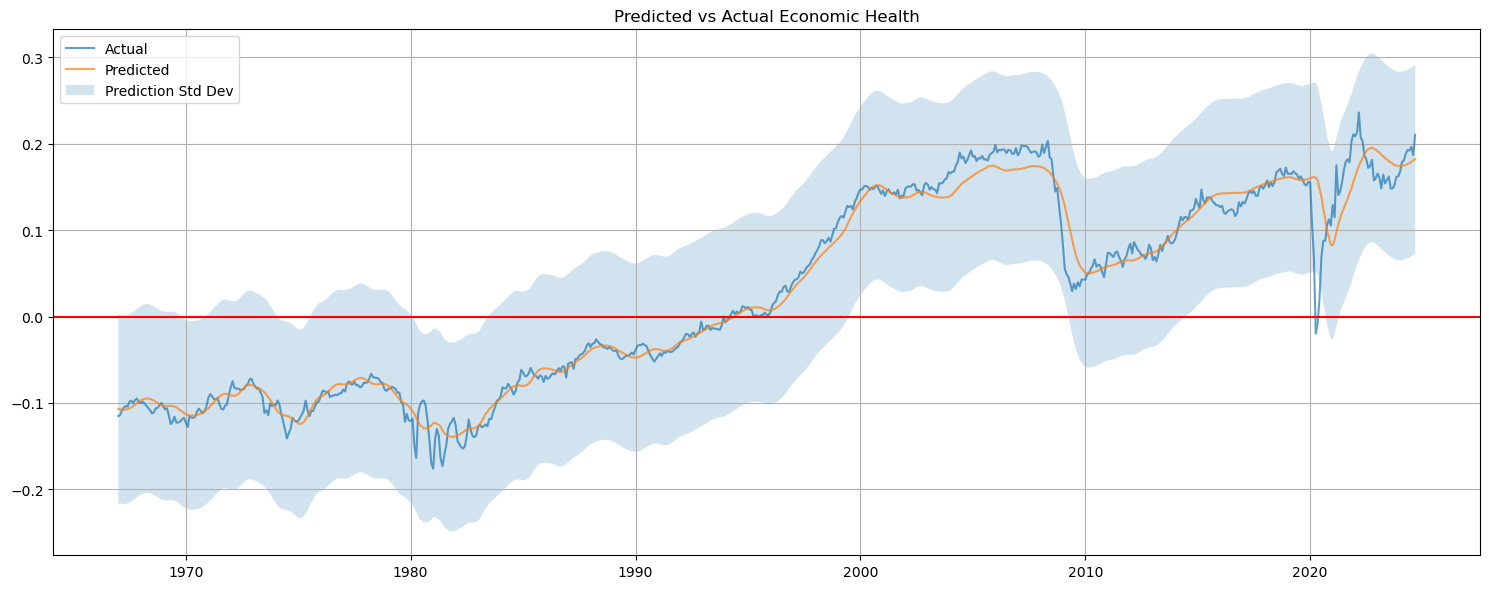

In [50]:
# Economic health prediction class.
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        
        Positive indicators (Sum = 1): 
        - GDP (core economic growth indicator)
        - INDPRO (industrial production)
        - SP500 (market stability)
        - PAYEMS (employment)
        - GDP_PCA (population welfare)
        - PASAVERT (population savings)
        - TAX (tax revenues)
        - INTEREST (interest payments on government loans)
        - T10YFF (yield curve slope)

        Negative indicators (Sum = -1):
        - DEBT (total public debt)
        - CPI (inflation)
        - UNEMPLOYMENT (unemployment)
        - FEDFUNDS (cost of borrowing)
        - DEBT_PER_GDP (debt burden)
        - TB (trade deficit)
        - ENERGY (energy costs)
        - FDEXPND (government spending)
        """
        weights = {
        # Positive indicators (total sum = 1).
            'gdp': 0.15,          # A key indicator of economic growth.
            'indpro': 0.15,       # Production capacity.
            'sp500': 0.1,         # Market confidence.
            'payems': 0.1,        # Employment.
            'gdp_pca': 0.15,      # Standard of living.
            'pasavert': 0.1,      # Household financial stability.
            'tax': 0.1,           # Tax revenues.
            'interest': 0.1,      # Interest payments.
            't10yff': 0.05,       # Yield curve slope.
    
        # Negative indicators (total sum = -1).
            'debt': -0.25,        # A major problem for the economy.
            'cpi': -0.15,         # Inflation.
            'unrate': -0.1,       # Social indicator.
            'fedfunds': -0.1,     # Impact on the cost of loans.
            'debt_per_gdp': -0.1, # Long-term financial stability.
            'tb': -0.15,          # Trade balance.
            'energy': -0.05,      # Energy dependence.
            'fgexpnd': -0.1       # Government spending.
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model.
        """
        model = Sequential([
            Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(256, return_sequences=True),
            Dropout(0.3),
            LSTM(128, return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=22, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

# Main analysis function.
def run_analysis(data):
    print("Training the model...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(data, epochs=22, validation_split=0.2, verbose=0)

    # Add back the training history plot.
    plot_training_history(history)

    # Making predictions.
    predictions = predictor.predict(data)
    health_score = predictor.create_composite_health_score(data)

    # Add model evaluation.
    metrics = model_evaluation(health_score[12:], predictions)
    
    # Print metrics.
    print("\nModel Eval. Metrics:", end=' ')
    print(", ".join(f"{metric}: {value:.3f}" for metric, value in metrics.items()))
    print("\n")
    
    # Visualization of predictions.
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return predictor, history, predictions, health_score, metrics

# Performing the analysis.
if __name__ == "__main__":
    # If we are loading data from a file.
    # data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(data)

**Model Loss**
**Loss** is a measure of how well or poorly a model performs during training. It is a numerical value that shows the difference between the model's predictions and the true values ​​(labels).
The Loss function depends on the type of task:
- For **regression**, **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)** is often used.
- For **classification**, **Cross-Entropy Loss** is often used.
The plot of **Loss** usually shows the value of the loss versus the epochs.
- **The goal is for the loss to decrease with each epoch**, which means the model is learning and getting better.
If the loss:
- Decreases smoothly: the model is training well.
- Stops decreasing or starts increasing: there may be **overfitting** (the model is adapting too much to the training data).
- Does not decrease at all: the model may not learn (it is possible that the learning rate is too small or the architecture is not suitable).

**Model MAE (Mean Absolute Error)**
**Mean Absolute Error (MAE)** is a metric that measures the average absolute difference between the predicted values ​​and the true values.
- The formula for MAE is: $$ MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i| $$
where: $ y_i \text{ are the true values, } \hat{y}_i \text{ are the predicted values} $, **n** is the number of examples.
Like Loss, MAE is also plotted against epochs.
- **The goal is for MAE to decrease over time**, indicating that the model is making more accurate predictions.
- MAE is easier to interpret than Loss because it is in the same units as the input data (for example, if you are predicting temperature in degrees, MAE will also be in degrees).

Are we done with this? Probably not. In the late 1970s, the US economy and the purchasing power of the dollar were in their heyday. And inflation over the decades does not stop working, which significantly distorts the picture. That is, if at the beginning we have apples, at the end of the period we have pears. How do we compare which is bigger, apples or pears?<br>
**<a style="color:purple;">For an objective analysis, we need to exclude inflation</a>** from the general picture. How? By multiplying the features that are measured in dollars by some factor that takes into account inflation.

#### 3.2 **Second simulation**:

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/https://fred.stlouisfed.org/series/CUUR0000SA0R)** we download information for the period of our study: **<a style="color:purple;">Purchasing Power of the Consumer Dollar in U.S. City Average (CUUR0000SA0R)</a>**. [xx] Units: **Index**, Frequency: Monthly.

In [54]:
deflator = pd.read_csv('data/CUUR0000SA0R.csv') # Loading data.
deflator.columns = ["date", "deflator"]
deflator['deflator'] = deflator['deflator'] / 100 # Convert the percentage index to a number.
deflator['date'] = pd.to_datetime(deflator['date'])
deflator.set_index('date', inplace=True)
deflator.tail()

,deflator
date,
2024-05-01,0.318
2024-06-01,0.318
2024-07-01,0.318
2024-08-01,0.318
2024-09-01,0.317


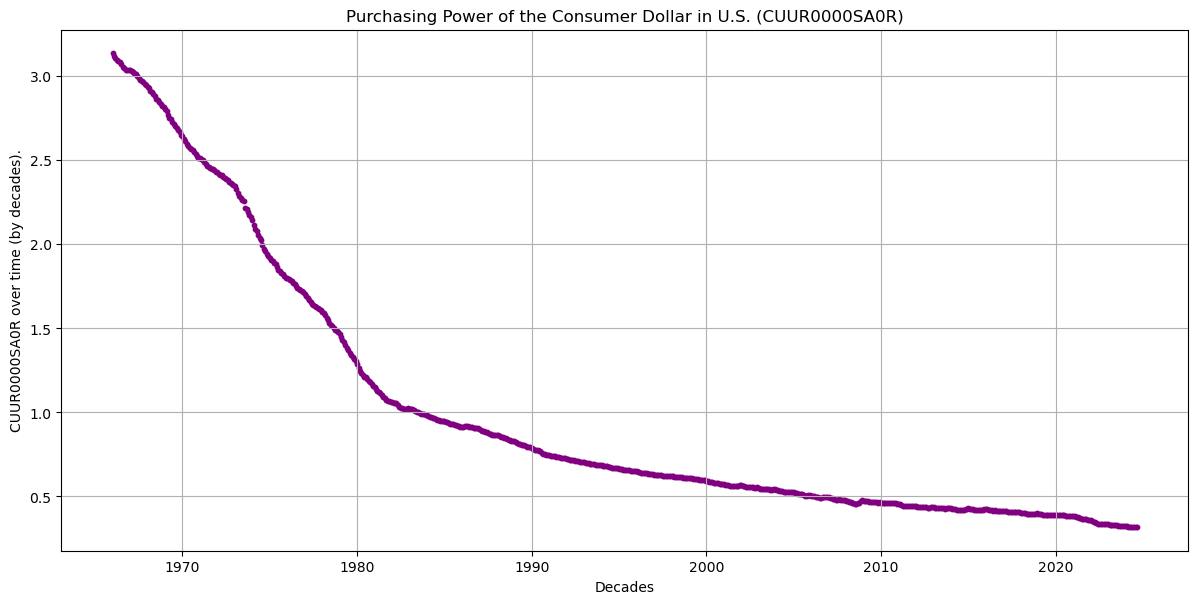

In [55]:
# Create the chart.
plt.figure(figsize=(12, 6))
plt.xlabel('Decades')
plt.grid(True)
plt.tight_layout()
plt.scatter(deflator.index, deflator['deflator'], s=10, color='purple') # s = the point size
# Readability settings.
plt.ylabel('CUUR0000SA0R over time (by decades).')
plt.title('Purchasing Power of the Consumer Dollar in U.S. (CUUR0000SA0R)')
plt.show()

In [56]:
# Create a copy of the original DataFrame.
adjusted_data = data.copy()

# List of dollar columns to be adjusted.
usd_columns = ['gdp', 'debt', 'gdp_pca', 'tb', 'energy', 'interest', 'tax', 'fgexpnd']

# Multiply the values ​​in the columns by the deflator.
for col in usd_columns:
    adjusted_data[col] = data[col] * deflator['deflator']

Once inflation is eliminated, another problem will arise. The economy will not go from boom to boom, from bright to even brighter future. And it will be almost impossible for the model to pass metrics with over 90% accuracy. It's tried and tested. More information describing anomalies in the economy could be added to help model efficiency. Two more features were chosen: recessions and the COVID-19 period. But this did not produce good results either.<br>
The problem was solved with **cross-validation** and adjustments to the model's hyperparameters. In addition, **months were removed from the COVID-19 period** in such a way as not to interfere with the trend in price movements. And why were they removed at all? Because of their **anti-market value**. At that time, businesses were being forced to close and "helicopter money" was being given out.

In [58]:
# Дефиниране на начална и крайна дата
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-11-01')

# Списък с всички колони
columns = ['gdp', 'cpi', 'indpro', 'sp500', 'payems', 'unrate', 'fedfunds', 
           'debt', 'pasavert', 'gdp_pca', 'debt_per_gdp', 'tb', 'energy', 
           'interest', 'tax', 'fgexpnd', 't10yff']

# Маска за избор на периода
period_mask = (adjusted_data.index >= start_date) & (adjusted_data.index <= end_date)

# Създаване на дейтафрейм с правилните колони и типове данни
data_dict = {col: pd.Series(dtype='float64') for col in columns}
interpolation_df = pd.DataFrame(data_dict, index=[start_date, end_date])

# Копиране на стойностите за началната и крайната дата
for col in columns:
    interpolation_df.loc[start_date, col] = float(adjusted_data.loc[start_date, col])
    interpolation_df.loc[end_date, col] = float(adjusted_data.loc[end_date, col])

# Добавяне на междинните дати и извършване на интерполация
interpolation_df = interpolation_df.reindex(adjusted_data.loc[period_mask].index)
interpolation_df = interpolation_df.interpolate(method='linear')

# Обновяване на оригиналния дейтафрейм
adjusted_data.loc[period_mask, columns] = interpolation_df[columns]

adjusted_data.to_csv(r'data/adjusted_data.csv') # We save the dataframe to a file.
# View the corrected DataFrame.
adjusted_data

,gdp,cpi,indpro,sp500,payems,unrate,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,energy,interest,tax,fgexpnd,t10yff
date,,,,,,,,,,,,,,,,,
1966-01-01,2.495422e+12,31.880,33.1709,92.88,62529.0,0.040,0.0442,1.006653e+12,0.112,75803.392000,0.403400,-1.097600e+07,9.784320e+10,6.096384e+10,3.094981e+11,4.266716e+11,0.288095
1966-02-01,2.490709e+12,32.080,33.3859,91.22,62796.0,0.038,0.0460,9.957801e+11,0.110,75388.043333,0.399798,-1.122480e+07,9.634620e+10,6.120426e+10,3.121700e+11,4.308109e+11,0.242632
1966-03-01,2.490697e+12,32.180,33.8429,89.23,63192.0,0.038,0.0466,9.868725e+11,0.107,75117.574667,0.396223,-1.149220e+07,9.690720e+10,6.155678e+10,3.153998e+11,4.357159e+11,0.229565
1966-04-01,2.491416e+12,32.280,33.8967,91.06,63437.0,0.038,0.0467,9.783202e+11,0.103,74871.145000,0.392676,-1.176100e+07,9.811150e+10,6.192476e+10,3.186983e+11,4.407125e+11,0.111500
1966-05-01,2.504108e+12,32.350,34.2192,86.13,63712.0,0.039,0.0490,9.862882e+11,0.112,74932.558667,0.393868,-1.205880e+07,9.894400e+10,6.235946e+10,3.197540e+11,4.449872e+11,-0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,9.262635e+12,313.225,103.0711,5277.51,158430.0,0.040,0.0533,1.114356e+13,0.052,21974.966000,1.203066,-2.394731e+10,2.487714e+11,3.509175e+11,9.815799e+11,2.202973e+12,-0.847727
2024-06-01,9.297956e+12,313.049,103.2258,5460.48,158548.0,0.041,0.0533,1.121066e+13,0.052,22015.246000,1.205713,-2.321909e+10,2.416800e+11,3.530554e+11,9.841018e+11,2.223006e+12,-1.024737
2024-07-01,9.333276e+12,313.534,102.5863,5522.30,158692.0,0.043,0.0533,1.127777e+13,0.049,22055.526000,1.208340,-2.509592e+10,2.438424e+11,3.551933e+11,9.866236e+11,2.243040e+12,-1.081364


Training the model...
Performing cross-validation...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Cross-Validation Metrics: rmse: 0.053, r2: 0.950, mae: 0.041


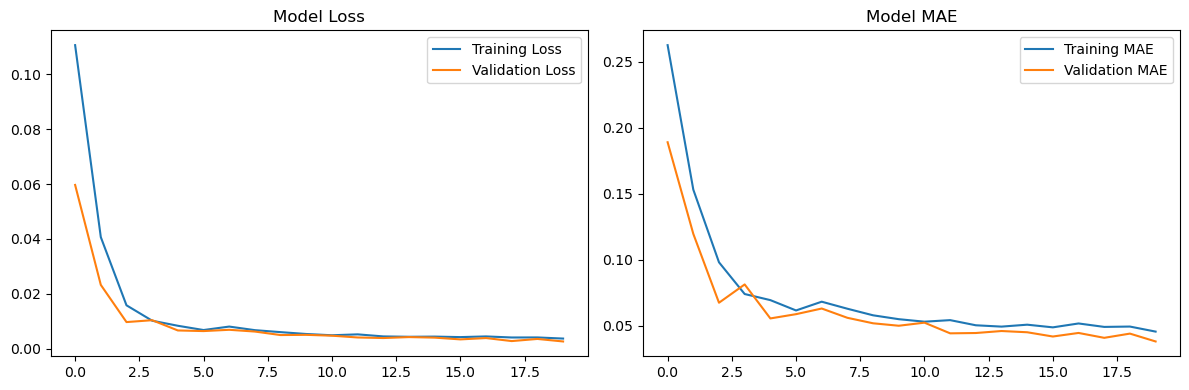


Model Eval. Metrics: rmse: 0.014, r2: 0.957, mae: 0.011




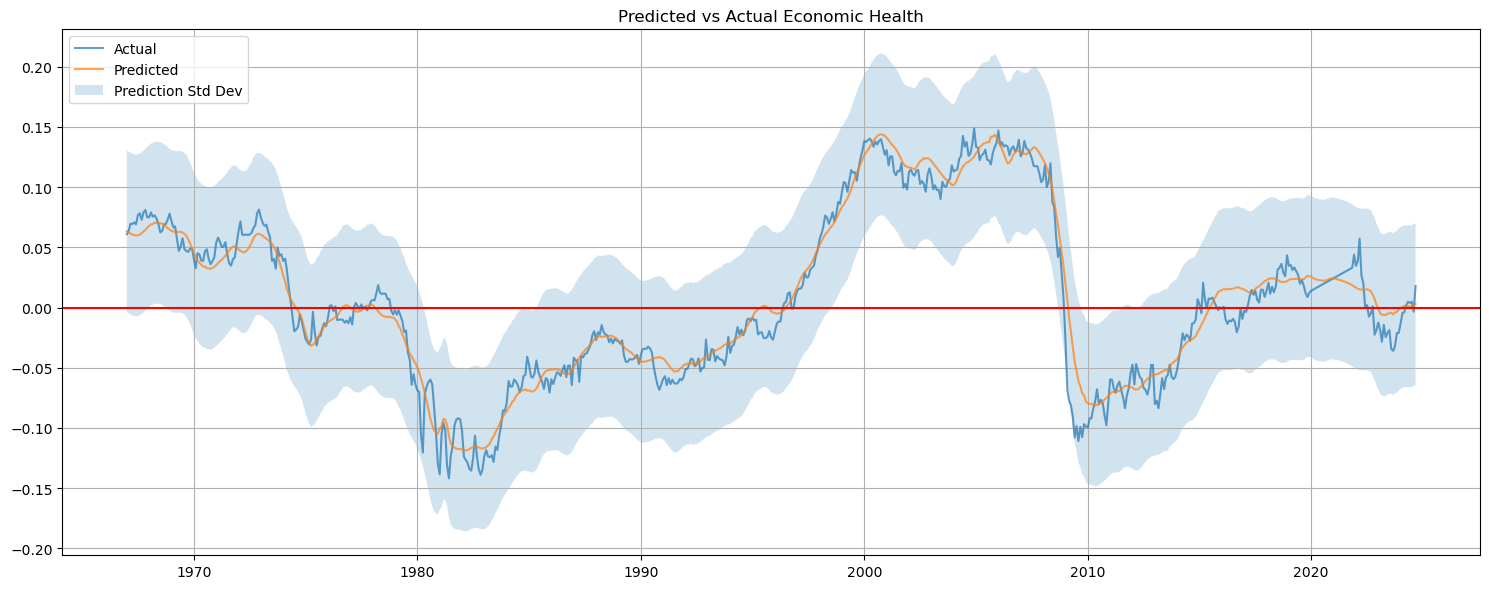

In [102]:
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, adjusted_data):
        weights = {
        # Positive indicators (total sum = 1).
            'gdp': 0.15,          # A key indicator of economic growth.
            'indpro': 0.15,       # Production capacity.
            'sp500': 0.1,         # Market confidence.
            'payems': 0.1,        # Employment.
            'gdp_pca': 0.15,      # Standard of living.
            'pasavert': 0.1,      # Household financial stability.
            'tax': 0.1,           # Tax revenues.
            'interest': 0.1,      # Interest payments.
            't10yff': 0.05,       # Yield curve slope.
    
        # Negative indicators (total sum = -1).
            'debt': -0.25,        # A major problem for the economy.
            'cpi': -0.15,         # Inflation.
            'unrate': -0.1,       # Social indicator.
            'fedfunds': -0.1,     # Impact on the cost of loans.
            'debt_per_gdp': -0.1, # Long-term financial stability.
            'tb': -0.15,          # Trade balance.
            'energy': -0.05,      # Energy dependence.
            'fgexpnd': -0.1       # Government spending.
       }
        normalized_data = self.scaler_X.fit_transform(adjusted_data)
        df_normalized = pd.DataFrame(normalized_data, columns=adjusted_data.columns)
        health_score = sum(df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns)
        return health_score

    def prepare_sequences(self, X, y):
       X_seq, y_seq = [], []
       for i in range(len(X) - self.lookback):
           X_seq.append(X[i:(i + self.lookback)])
           y_seq.append(y[i + self.lookback])
       return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
       """
       Creates a model.
       """
       model = Sequential([
           Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
           MaxPooling1D(pool_size=2),
           LSTM(512, return_sequences=True),
           Dropout(0.4),
           LSTM(256, return_sequences=True),
           Dropout(0.3),
           LSTM(128, return_sequences=False),
           Dropout(0.2),
           Dense(64, activation='relu'),
           Dense(1)
       ])
       optimizer = Adam(learning_rate=1e-3)
       model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
       return model

    def fit(self, adjusted_data, epochs=20, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(adjusted_data)
        X_scaled = self.scaler_X.fit_transform(adjusted_data)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, adjusted_data.shape[1]))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose,
            batch_size=32
        )
        return history

    def cross_validate(self, adjusted_data, epochs=20, k=5):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        metrics_list = []

        y = self.create_composite_health_score(adjusted_data)
        X_scaled = self.scaler_X.fit_transform(adjusted_data)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))
        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)

        for train_index, test_index in kf.split(X_seq):
            X_train, X_test = X_seq[train_index], X_seq[test_index]
            y_train, y_test = y_seq[train_index], y_seq[test_index]

            self.model = self.build_model((self.lookback, adjusted_data.shape[1]))
            history = self.model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=32, validation_data=(X_test, y_test))

            preds = self.model.predict(X_test)
            metrics = model_evaluation(y_test, preds)
            metrics_list.append(metrics)

        avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0]}
        return avg_metrics, history

    def predict(self, adjusted_data):
        X_scaled = self.scaler_X.transform(adjusted_data)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

# Main analysis function.
def run_analysis(adjusted_data):
    print("Training the model...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(adjusted_data, epochs=20, validation_split=0.2, verbose=0)

    # Cross-validation
    print("Performing cross-validation...")
    cv_metrics, cv_history = predictor.cross_validate(adjusted_data, epochs=20, k=5)
    print("Cross-Validation Metrics: " + ", ".join(f"{metric}: {value:.3f}" for metric, value in cv_metrics.items())) ##
    # print(", ".join(f"{metric}: {value:.3f}" for metric, value in cv_metrics.items()))

    # Plot training history after cross-validation
    plot_training_history(cv_history)

    # Making predictions.
    predictions = predictor.predict(adjusted_data)
    health_score = predictor.create_composite_health_score(adjusted_data)
    
    # Add model evaluation.
    metrics = model_evaluation(health_score[12:], predictions)
    
    # Print metrics.
    print("\nModel Eval. Metrics:", end=' ')
    print(", ".join(f"{metric}: {value:.3f}" for metric, value in metrics.items()))
    print("\n")

    # Visualization of predictions.
    plot_predictions(health_score[12:], predictions, adjusted_data.index[12:])
    return predictor, history, predictions, health_score, metrics

# Performing the analysis.
if __name__ == "__main__":
    # If we are loading adjusted data from a file.
    adjusted_data = pd.read_csv("data/adjusted_data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(adjusted_data)

Bingo! Those who know the phases of development of the US economy **can now clearly determine the periods of rise, fall and stagnation! <a style="color:purple;">And they coincide with what historical truth says</a>**.

### 4. **Debt forecasting**

**Input**: GDP, FEDFUNDS, UNRATE, PCEPI, GFDEBTN, XAU<br>
**Target**: Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S) - after 12 months<br>
**Model**: Transformer architecture<br>
**Objective**: To predict when debt will reach 175% of GDP

### 5. **Conclusions**

### Resources:
1. **Sustainable Economic Indicators**: https://www.sustainable-environment.org.uk/Indicators/Economy.php
2. **...**: ....
3. **...**: ....
4. **...**: ....
5. **...**: ....
6. **...**: ....
7. **...**: ....
8. **...**: ....
9. **...**: ....
10. **...**: ....
11. **...**: ....
12. **...**: ....
13. **...**: ....
14. **...**: ....
15. **...**: ....